<a href="https://colab.research.google.com/github/WorstCoder-Ma/ST456/blob/main/w01_lecture_LinearRegression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(LSE - ST456 DEEP LEARNING - WT2024)

# Linear regression model

This notebook implements a **linear regression model from scratch**, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimiser.

It is intended to be used for self-study and as a suplement to lecture content.

At the end, we show how to specify the same model using [TensorFlow Functional API](https://www.tensorflow.org/guide/keras/functional_api) (also known as *low-level API*)

---


## Notes for running this code on Google Colab

* We don't need hardware accelerators for now. Notebook settings (Edit menu) can be leave as is (default option = `None`).
* We won't be using examples from any reference books for now. Just *standard* examples from the Tensorflow documentation and common practice.

---

## Step 0: importing necessary libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
# tensorflow is our main frawework for deep learning
import tensorflow as tf

## Step 1: generating a synthetic dataset

To keep things simple, we will **construct an artificial dataset
according to a linear model with additive noise.**
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.

In the following code snippet, we generate a dataset
containing 1,000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$**,
and our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.

The following code generates our synthetic dataset.


In [ ]:
# synthetic data generation function
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    # tensor filled with zeros
    X = tf.zeros((num_examples, w.shape[0]))
    # initial values from random distribution
    X += tf.random.normal(shape=X.shape)
    # dot product X * w plus bias
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    # add random noise
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [ ]:
# setting parameters (w, b)
true_w = tf.constant([2, -3.4])
true_b = 4.2
# generating the dataset with 1,000 samples
features, labels = synthetic_data(true_w, true_b, 1000)
# checking the dataset structure (first sample)
print('features:', features[0], '\nlabel:', labels[0])

features: tf.Tensor([-0.17599694  1.4944768 ], shape=(2,), dtype=float32) 
label: tf.Tensor([-1.2257875], shape=(1,), dtype=float32)


Note that **each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar).**


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


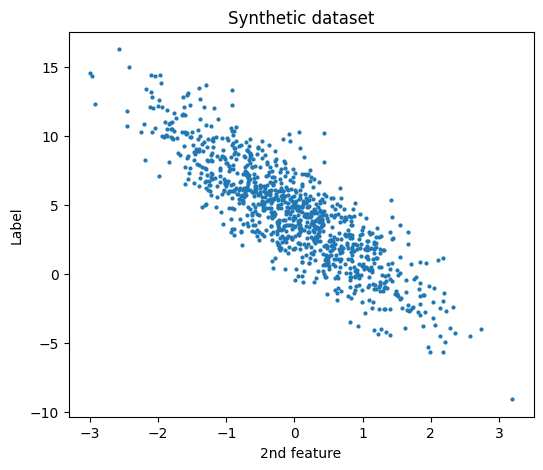

In [ ]:
# plotting the dataset for visualisation
# feel free to change the figsize
fig = plt.figure(figsize=(6, 5))
# parameters are: X feature, Y label, size of data points (feel free to change it)
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 4)
plt.title("Synthetic dataset")
plt.xlabel("2nd feature")
plt.ylabel("Label")
plt.show()

---

## Step 2: linear regression model (from scratch)


`[based on the D2L reference book]`

While modern deep learning frameworks can automate nearly all of this work, implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it comes time to customize models,
defining our own layers or loss functions, understanding how things work under the hood will prove handy.

In this section, we will rely only on **(i) tensors for data storage and linear algebra,
and (ii) auto differentiation for calculating gradients**.

### 2.1: reading the dataset

Recall that training models consists of
making multiple passes over the dataset,
grabbing one minibatch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a **utility function
to shuffle the dataset and access it in minibatches**.

In the following code, we **define the `data_iter` function** to demonstrate one possible implementation of this functionality. The function **takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`**. Each minibatch consists of a tuple of features and labels.


In [ ]:
# data iterator/loader function
def data_iter(batch_size, features, labels):
    # how many features
    num_examples = len(features)
    # indices for all features
    indices = list(range(num_examples))
    # the examples are read at random
    random.shuffle(indices)
    # iterate over all features given the batch size
    for i in range(0, num_examples, batch_size):
        # creates a constant tensor from a tensor-like object
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        # returns the tensor
        yield tf.gather(features, j), tf.gather(labels, j)

In general, note that we want to use reasonably sized minibatches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in scarcely more time
than it might take to process just a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


In [ ]:
# minibatch size
# you can ajust to match your problem requirements (e.g., larger batches for using GPUs)
batch_size = 10

# checking the data sample structure
for X, y in data_iter(batch_size, features, labels):
    print("Features:\n", X, "\n\nLabels:\n", y)
    break

Features:
 tf.Tensor(
[[ 0.79380214  1.1638427 ]
 [-0.73735374 -0.7482691 ]
 [-0.48069477  0.8921894 ]
 [-1.1540174  -0.2114037 ]
 [ 0.45279223  1.5213    ]
 [-0.36017817 -0.03113028]
 [ 0.36189103 -0.6707544 ]
 [-0.8490193   0.06500974]
 [-1.7530006   0.62214947]
 [ 0.65881234  2.33071   ]], shape=(10, 2), dtype=float32) 

Labels:
 tf.Tensor(
[[ 1.8223872 ]
 [ 5.272903  ]
 [ 0.20326053]
 [ 2.6276374 ]
 [-0.07397173]
 [ 3.5793939 ]
 [ 7.189084  ]
 [ 2.272732  ]
 [-1.4028391 ]
 [-2.4318013 ]], shape=(10, 1), dtype=float32)


As we run the iteration, we obtain distinct minibatches
successively until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with both data stored in files and data fed via data streams.


### 2.2: initialising model parameters

**Before we can begin optimizing our model's parameters**, by minibatch stochastic gradient descent or any other optimisation function,
**we need some initial parameters.**

Below, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0. `trainable=True` means all weights and the bias will be updated by the optimizer during training until they fit our data sufficiently well.


In [ ]:
# Initial weights and bias
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

In [ ]:
# checking initial values for w and b
print("Initial weights vector:\n", w, "\n\nInitial bias:\n", b)

Initial weights vector:
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.00136837],
       [0.00427361]], dtype=float32)> 

Initial bias:
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>



### 2.3: defining the model

Next, we must **define our model,
relating its inputs and parameters to its outputs.**

Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.

Note that $\mathbf{Xw}$  is a vector and $b$ is a scalar, and recall that when we add a vector and a scalar,
the scalar is added to each component of the vector (through the [broadcasting](https://www.tensorflow.org/xla/broadcasting) mechanism).



In [ ]:
# linear regression model
def linear_reg(X, w, b):
    """The linear regression model."""
    # dot product of X and w plus the bias
    return tf.matmul(X, w) + b

### 2.4: defining the loss function

Since **updating our model requires taking
the gradient of our loss function**,
we ought to **define the loss function first**.

Here we will use the *squared loss function*.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [ ]:
# loss function - square loss
def squared_loss(y_hat, y):
    """Squared loss."""
    #return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2
    return (tf.reshape(y, y_hat.shape) - y_hat)**2 / 2

### 2.5: defining the optimisation algorithm

Despite linear regression has a closed-form (analytic) solution, other deep learning models don't. So, we will use the **minibatch stochastic gradient descent** algorithm.

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters in the direction that may reduce the loss.

The following code applies the minibatch stochastic gradient descent update,
given a `set of parameters`, a `learning rate`, and a `batch size`.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalise our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.


In [ ]:
# optimisation function - minibatch stochastic gradient descent
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad / batch_size)

### 2.6: training the model

Now that we have all of the parts in place,
we are ready to **implement the main training loop.**

It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout most deep learning courses and materials.

In each iteration (or *epoch*), we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backward pass through the network,
storing the gradients with respect to each parameter ( we use [automatic differentiation](https://www.tensorflow.org/guide/autodiff) for calculating gradients). Finally, we will call the optimization algorithm to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*, we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).

The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters, which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.

In [ ]:
# model hyperparameters
lr = 0.03           # learning reate
num_epochs = 5      # number of training steps
model = linear_reg  # model
loss = squared_loss # loss function

In [ ]:
# main training loop
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
          # minibatch loss in X and y
          l = loss(model(X, w, b), y)
        # compute gradient on l with respect to [w, b]
        dw, db = g.gradient(l, [w, b])
        # update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(model(features, w, b), labels)
    print(f'Epoch {epoch + 1}, Loss {float(tf.reduce_mean(train_l)):f}')

In this case, because we synthesised the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can **evaluate our success in training
by comparing the true parameters
with those that we learned** through our training loop.
Indeed they turn out to be very close to each other.


In [ ]:
# Model accuracy during training
print('True w: ', true_w)
print('w: ', w)
print(f'Error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'Error in estimating b: {true_b - b}')

Note that we should not take it for granted
that we are able to recover the parameters perfectly.
However, in machine learning, we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to highly accurate prediction.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.

---

### Summary

* We saw how a simple model can be implemented and optimised from scratch, using just **tensors and auto differentiation**, without any need for defining layers or fancy optimisers.

---

### Implementation using the Functional API

`[from documentation]:` The Keras functional API is a way to **create models that are more flexible** than the `keras.Sequential API` (covered in the seminars). The functional API can handle **models with non-linear topology, shared layers, and even multiple inputs or outputs**.

The main idea is that **a deep learning model is usually a directed acyclic graph (DAG) of layers**. So the functional API is a way to build graphs of layers.

The basic steps are:

* specify the input layer (`tf.kerasInput`) with proper format
* specify any intermediate (hidden) layers, such as `tf.keras.layers.Dense`, using the previous layer as input to the current layer
* specify the output layer, with proper activation function
* specify the model (`tf.keras.Model`) with proper inputs and outputs

In the following example, we implement a single-layer linear regression model and use the same synthetic data for demonstration.


In [ ]:
# input layer and input shape (2 in this case, referring to our synthetic features)
input = tf.keras.Input(shape=(2,))
# the linear regression model applied to the input features
output = tf.keras.layers.Dense(1)(input)
# the model architecture - input and output layers
model2 = tf.keras.Model(inputs=input, outputs=output)
# model parameters - optimiser, loss function, and performance metrics
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03), loss=tf.keras.losses.MeanSquaredError(), metrics=['acc'])
# we train the model for a few epochs
model2.fit(features, labels, epochs=5, verbose=2)